In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uw-madison-gi-tract-image-segmentation/sample_submission.csv
/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0016_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0115_266_266_1.50_1.50.png
/kaggle/input/uw-madison-gi-tract-im

# 🔴 **Environment Setup**

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

In [1]:
!pip install -q torchmetrics

In [2]:
!pip install -q portalocker>=2.0.0

In [3]:
!pip install -q segmentation-models-pytorch

# 🔴 **Import Libs**

In [4]:
import os
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torchvision
from torchvision.transforms import v2
from torchvision.transforms import functional as TF
from torchvision import tv_tensors

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F

import segmentation_models_pytorch as smp
import torchmetrics as tm
from torchmetrics.aggregation import MeanMetric

# 🔴 **Utils**

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [6]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [7]:
def show_picture(image, mask):
    mask = mask.reshape((image.shape))
    cmap = mcolors.ListedColormap(['none', '#00FFFF', '#00FF00', '#FF0000'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, norm=norm, alpha=0.4)
    plt.colorbar()

# 🔴 **Arguments**

In [9]:
seed = 8

wandb_enable = False

backbone = 'efficientnet-b1'

num_classes = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 🔴 **Dataset**

## 🟠 Load the Dataset

In [10]:
df = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')
df.head()

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

In [11]:
train_cases = ['case129','case2','case131','case134','case6','case135','case9','case7','case139',
               'case140','case11','case142','case136','case141','case145','case18','case19','case148',
               'case149','case22','case146','case24','case144','case154','case156','case29','case30',
               'case32','case34','case36','case40','case41','case43','case44','case47','case49','case53',
               'case54','case55','case138','case63','case65','case66','case80','case81','case88','case90',
               'case91','case101','case102','case107','case108','case111','case113','case114','case115',
               'case116','case117','case118','case121','case125']
valid_cases = ['case33','case130','case133','case122','case16','case84','case20','case58','case92']
test_cases = ['case67','case35','case42','case74','case77','case110','case15','case143','case78',
              'case147','case85','case119','case89','case123','case124']
train_imgs, valid_imgs, test_imgs = [], [], []

for dirname, _, filenames in os.walk('/kaggle/input/uw-madison-gi-tract-image-segmentation/train'):
    for filename in filenames:
        if dirname.split('/')[5] in train_cases:
            train_imgs.append(os.path.join(dirname, filename))
        elif dirname.split('/')[5] in valid_cases:
            valid_imgs.append(os.path.join(dirname, filename))
        elif dirname.split('/')[5] in test_cases:
            test_imgs.append(os.path.join(dirname, filename))


In [12]:
normalizer = lambda x: (x - x.min()) / (x.max() - x.min())

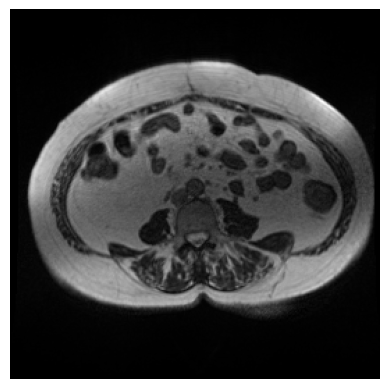

In [13]:
idx = 1
image = Image.open(train_imgs[idx])
image = TF.to_tensor(image)
image = normalizer(image[0])

plt.imshow(image, cmap='gray')
plt.axis(False);

In [14]:
name = '{}_{}_{}'.format(train_imgs[idx].split('/')[-3],
                        train_imgs[idx].split('/')[-1].split('_')[0],
                        train_imgs[idx].split('/')[-1].split('_')[1]
                        )
related_df = df[df['id']==name]
related_df


id        class  \
86115  case36_day14_slice_0082  large_bowel   
86116  case36_day14_slice_0082  small_bowel   
86117  case36_day14_slice_0082      stomach   

                                            segmentation  
86115  25203 4 25467 8 25600 6 25732 11 25864 8 25997...  
86116  18482 5 18747 6 19012 8 19278 8 19544 8 19810 ...  
86117                                                NaN

In [15]:
rle_mask = related_df.iloc[0, :]['segmentation']
rle_list = rle_mask.split(' ')
starts, lengths = rle_list[::2], rle_list[1::2]
starts = np.array(starts, dtype=np.int32) - 1
lengths = np.array(lengths, dtype=np.int32)
ends = starts + lengths

In [16]:
mask = torch.zeros(image.numel(), dtype=torch.float32)
for start, end in zip(starts, ends):
    mask[start:end]=1


In [17]:
mask2 = mask.reshape((image.shape))
mask2.shape

torch.Size([266, 266])

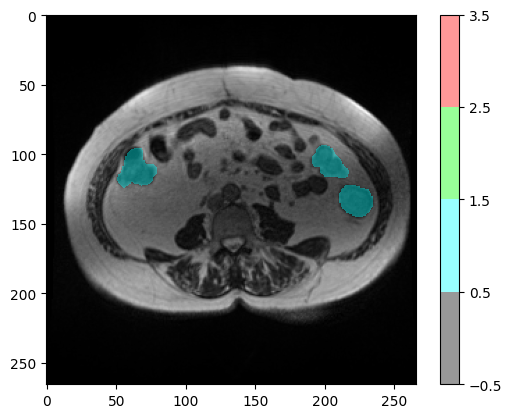

In [18]:
show_picture(image, mask2)

In [19]:
pivot = df.pivot_table(index='id', columns='class', values='segmentation', aggfunc='first').reset_index()
pivot

class                        id  \
0      case101_day20_slice_0066   
1      case101_day20_slice_0067   
2      case101_day20_slice_0068   
3      case101_day20_slice_0069   
4      case101_day20_slice_0070   
...                         ...   
16585    case9_day22_slice_0115   
16586    case9_day22_slice_0116   
16587    case9_day22_slice_0117   
16588    case9_day22_slice_0118   
16589    case9_day22_slice_0119   

class                                        large_bowel  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
16585  38022 2 38380 7 38739 9 39099 10 39295 6 39459...   
16586  38021 4 38379 8 38739 10 38938 2 39099 10 3929...   
16587  38020 7 38379 10 38738 12 38936 4 39098 12 392...   
16588  37661 5 38019 10 38378 12 38738 12 39097 14 39...   
16589  37658 11 38017 13 38377 13 38737 13 39097 13 3...   

class                                        small_bowel  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
16585  21360 7 21718 10 22077 12 22435 15 22788 1 227...   
16586  21361 3 21718 9 22076 12 22435 14 22794 17 231...   
16587  21717 8 22076 11 22434 15 22791 20 23149 25 23...   
16588  21359 6 21717 10 22074 15 22431 20 22790 23 23...   
16589  20998 7 21357 11 21714 15 22071 20 22430 22 22...   

class                                            stomach  
0      32107 5 32371 10 32635 13 32900 15 33165 17 33...  
1      31313 2 31577 7 31841 10 32105 14 32369 17 326...  
2      30517 2 30781 6 31046 9 31311 11 31575 15 3184...  
3      29981 10 30246 13 30511 16 30776 19 31041 21 3...  
4      28918 9 29182 14 29446 18 29711 21 29976 23 30...  
...                                                  ...  
16585                                                NaN  
16586                                                NaN  
16587                                                NaN  
16588                                                NaN  
16589                                                NaN  

[16590 rows x 4 columns]

In [20]:
def create_dataset(phase):
    ids = []
    large_bowels = []
    small_bowels = []
    stomachs =[]
    path = []
    if phase=='train':
        pathes = train_imgs
    elif phase=='valid':
        pathes = valid_imgs
    elif phase=='test':
        pathes = test_imgs
        
    for idx in range(len(pathes)):
        name = '{}_{}_{}'.format(pathes[idx].split('/')[-3],
                                pathes[idx].split('/')[-1].split('_')[0],
                                pathes[idx].split('/')[-1].split('_')[1]
                            )
        if len(pivot[pivot['id']==name])!=0:
            path.append(pathes[idx])
            ids.append(pivot[pivot['id']==name]['id'].values[0])
            large_bowels.append(pivot[pivot['id']==name]['large_bowel'].values[0])
            small_bowels.append(pivot[pivot['id']==name]['small_bowel'].values[0])
            stomachs.append(pivot[pivot['id']==name]['stomach'].values[0])
    
    dataset = pd.DataFrame({'id':ids, 'path':path, 'large_bowel':large_bowels, 'small_bowel':small_bowels, 'stomach':stomachs})
    print(f'{phase} is done!')
    return dataset

In [21]:
train_set = create_dataset('train')
valid_set = create_dataset('valid')
test_set = create_dataset('test')

train is done!
valid is done!
test is done!


## 🟠 Custom dataset

In [22]:
def rle_decode(im_size, segments):
    mask = torch.zeros(3, im_size[0]*im_size[1], dtype=torch.int32)
    for i, segment in enumerate(segments):
        if str(segment)!='nan':
            segment = segment.split()
            starts = np.array(segment[::2], dtype=np.int32) - 1
            ends = starts + np.array(segment[1::2], dtype=np.int32)
            for start, end in zip(starts, ends):
                mask[i, start:end] = 1
    return mask.reshape((3, im_size[0], im_size[1]))

In [23]:
class MedicalDataset(Dataset):
    def __init__(self, phase, transforms):
        
        self.transforms = transforms
        
        if phase=='train':
            self.df = train_set.copy()
        elif phase=='valid':
            self.df = valid_set.copy()
        else:
            self.df = test_set.copy()
            
        self.classes = ['large_bowel', 'small_bowel', 'stomach']
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = Image.open(sample['path'])
        mask = rle_decode(image.size[::-1], sample[self.classes])
        
        image = tv_tensors.Image(image)
        mask = tv_tensors.Mask(mask)

        image, mask = self.transforms(image, mask)
        mask = mask.int()
        return image, mask
    
    def __len__(self):
        return len(self.df)

In [24]:
train_transform = v2.Compose([
    v2.Resize(size=(234,), antialias=True),
    v2.RandomCrop(size=(224, 224)),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1))
])
eval_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1))
])

In [25]:
train = MedicalDataset('train' ,train_transform)
valid = MedicalDataset('valid' ,eval_transform)
test = MedicalDataset('test' ,eval_transform)

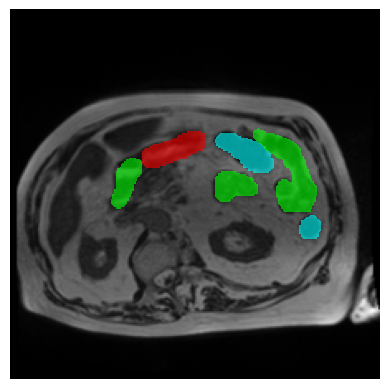

In [26]:
image, mask = valid[250]

plt.imshow(image[0, :, :], cmap='gray')
for i, color in zip(range(3), ['#00FFFF', '#00FF00', '#FF0000']):
    cmap = mcolors.ListedColormap(['none', color])
    plt.imshow(mask[i, :, :], cmap=cmap, alpha=0.6)
plt.axis(False);

## 🟠 Dataloader

In [27]:
train_loader = DataLoader(train, 32, True)
valid_loader = DataLoader(valid, 32, False)
test_loader = DataLoader(test, 32, False)

# 🔴 **Model**

In [28]:
unet = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 36.6MB/s]


In [31]:
unetplusplus = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3)

In [33]:
deeplabv3 = smp.DeepLabV3(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3)

# 🔴 **Config**

In [34]:
loss_fn = smp.losses.DiceLoss(mode='multilabel')
metric = tm.Dice().to(device)

# 🔴 **Train ➰**

In [35]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    loss_train = MeanMetric()
    metric.reset()
    
    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch {epoch}')

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item(), weight=len(targets))
            metric.update(outputs, targets)
            
            tepoch.set_postfix(loss=loss_train.compute().item(),
                               metric=metric.compute().item())

    return model, loss_train.compute().item(), metric.compute().item()

# 🔴 **Evaluation**

In [36]:
def evaluate(model, test_loader, loss_fn, metric):
    model.eval()
    loss_eval = MeanMetric()
    metric.reset()
    
    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            loss_eval.update(loss.item(), weight=len(targets))
            
            metric(outputs, targets)


    return loss_eval.compute().item(), metric.compute().item()

# **1.UNet**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [37]:
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(0.9717, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [38]:
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [39]:
mini_set, _ = random_split(valid, (500, len(valid)-500))
mini_loader = DataLoader(mini_set, 20, shuffle=True)

In [40]:
num_epochs = 10
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_loader, loss_fn, optimizer, metric, epoch+1)

Epoch 10: 100%|██████████| 25/25 [00:10<00:00,  2.34batch/s, loss=0.278, metric=0.696]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [46]:
num_epochs = 3

for lr in [0.5, 0.3, 0.1]:
    print(f'LR={lr}')

    model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, epoch+1)

    print()

LR=0.5


Epoch 3: 100%|██████████| 47/47 [00:31<00:00,  1.47batch/s, loss=0.58, metric=0.429] 



LR=0.3


Epoch 3: 100%|██████████| 47/47 [00:32<00:00,  1.47batch/s, loss=0.516, metric=0.494]



LR=0.1


Epoch 3: 100%|██████████| 47/47 [00:32<00:00,  1.46batch/s, loss=0.619, metric=0.39] 

it seems like 0.1 is the best learning rate for this model.so lets use it!😉

## Main Loop

In [47]:
torch.cuda.empty_cache()

🔰 Define train dataloader.

In [50]:
set_seed(seed)
train_loader = DataLoader(train, 32, True)
valid_loader = DataLoader(valid, 32, False)

model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
               in_channels=3, classes=3).to(device)

In [51]:
set_seed(seed)
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)

In [52]:
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [53]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
    model, loss_train, metric_train = train_one_epoch(model,
                                     train_loader,
                                     loss_fn,
                                     optimizer,
                                     metric,
                                     epoch+1)
    # Validation
    loss_valid, metric_valid = evaluate(model,
                         valid_loader,
                         loss_fn,
                         metric)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)
    
    if loss_valid < best_loss_valid:
        torch.save(model, f'/kaggle/working/unetModel.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}, LR = {lr_scheduler.get_last_lr()[0]}')
    print()
    
    lr_scheduler.step()

    epoch_counter += 1

Epoch 1: 100%|██████████| 376/376 [05:57<00:00,  1.05batch/s, loss=0.479, metric=0.282]


Model Saved!
Valid: Loss = 0.3075, Metric = 0.7015, LR = 0.1



Epoch 2: 100%|██████████| 376/376 [04:23<00:00,  1.43batch/s, loss=0.204, metric=0.791]


Model Saved!
Valid: Loss = 0.2662, Metric = 0.7432, LR = 0.1



Epoch 3: 100%|██████████| 376/376 [04:26<00:00,  1.41batch/s, loss=0.171, metric=0.823]


Model Saved!
Valid: Loss = 0.2507, Metric = 0.7504, LR = 0.1



Epoch 4: 100%|██████████| 376/376 [04:23<00:00,  1.43batch/s, loss=0.156, metric=0.838]


Model Saved!
Valid: Loss = 0.2364, Metric = 0.7669, LR = 0.1



Epoch 5: 100%|██████████| 376/376 [04:23<00:00,  1.43batch/s, loss=0.147, metric=0.848]


Valid: Loss = 0.2476, Metric = 0.7478, LR = 0.1



Epoch 6: 100%|██████████| 376/376 [04:24<00:00,  1.42batch/s, loss=0.131, metric=0.864]


Model Saved!
Valid: Loss = 0.2165, Metric = 0.7819, LR = 0.010000000000000002



Epoch 7: 100%|██████████| 376/376 [04:25<00:00,  1.41batch/s, loss=0.126, metric=0.869]


Model Saved!
Valid: Loss = 0.2144, Metric = 0.7847, LR = 0.010000000000000002



Epoch 8: 100%|██████████| 376/376 [04:23<00:00,  1.43batch/s, loss=0.124, metric=0.871]


Model Saved!
Valid: Loss = 0.2124, Metric = 0.787, LR = 0.010000000000000002



Epoch 9: 100%|██████████| 376/376 [04:23<00:00,  1.42batch/s, loss=0.122, metric=0.873]


Model Saved!
Valid: Loss = 0.2122, Metric = 0.7874, LR = 0.010000000000000002



Epoch 10: 100%|██████████| 376/376 [04:24<00:00,  1.42batch/s, loss=0.12, metric=0.875] 


Valid: Loss = 0.2144, Metric = 0.7861, LR = 0.010000000000000002



## 🟠 Plot

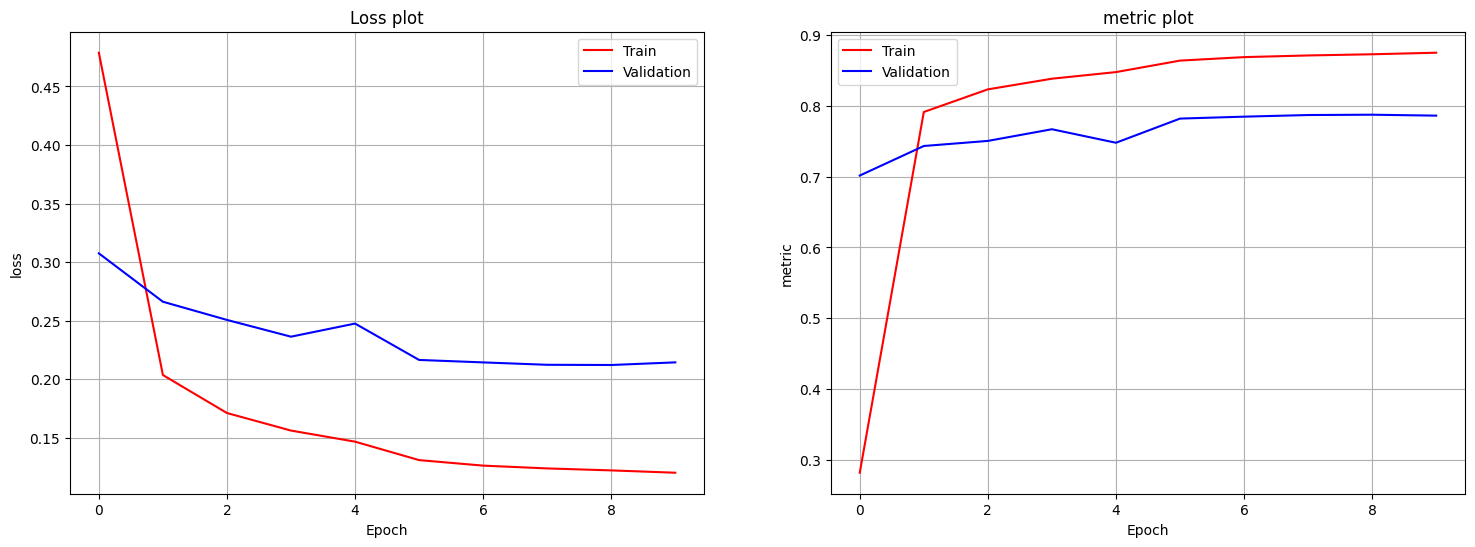

In [57]:

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
plt.title('Loss plot')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation')
plt.title('metric plot')
plt.xlabel('Epoch')
plt.ylabel('metric')
plt.grid(True)
plt.legend()

## **Test**

In [65]:
model = torch.load('/kaggle/working/unetModel.pt').to(device)
model.eval()

loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)
print(f'loss test = {loss_test} , metric test = {metric_test}')

/tmp/ipykernel_36/1518055873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/unetModel.pt').to(device)


loss test = 0.2255440503358841 , metric test = 0.7856225967407227


# 🔴 **Segment**

In [67]:
model_path = '/kaggle/working/unetModel.pt'
model = torch.load(model_path)
model.eval();

/tmp/ipykernel_36/3948309211.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [68]:
def segment(image, model):
    with torch.inference_mode():
        prediction = model(image)
    return torch.sigmoid(prediction).cpu()

In [69]:
test_loader = DataLoader(test, batch_size=1, shuffle=True)

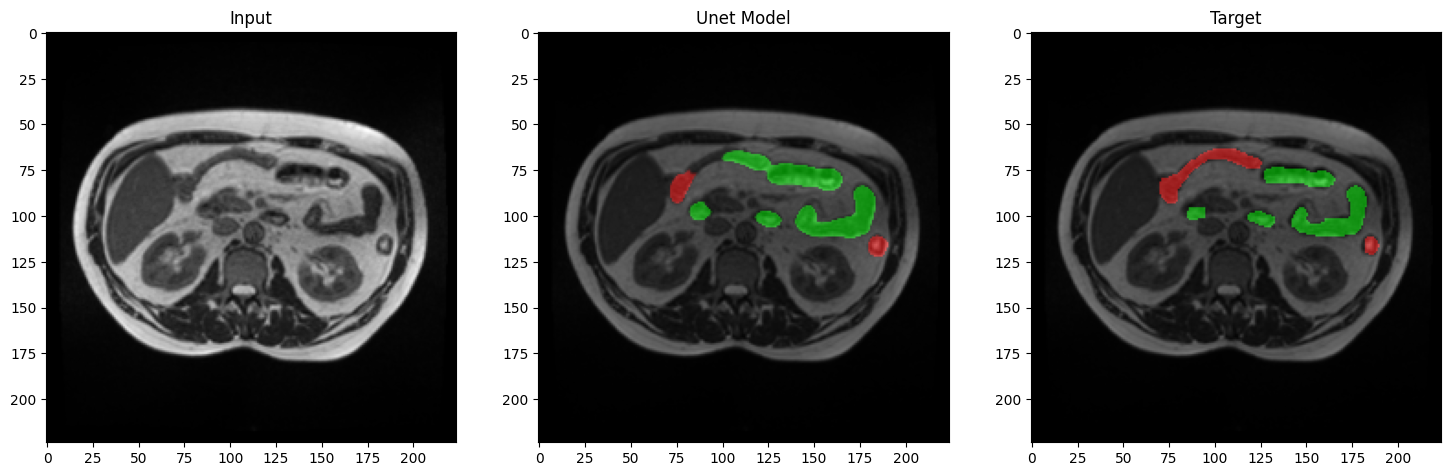

In [79]:
img, mask = next(iter(test_loader))

output = segment(img.to(device), model)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.5);
plt.title('Unet Model')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(mask[0].permute(1, 2, 0).float(), alpha=0.5);
plt.title('Target');

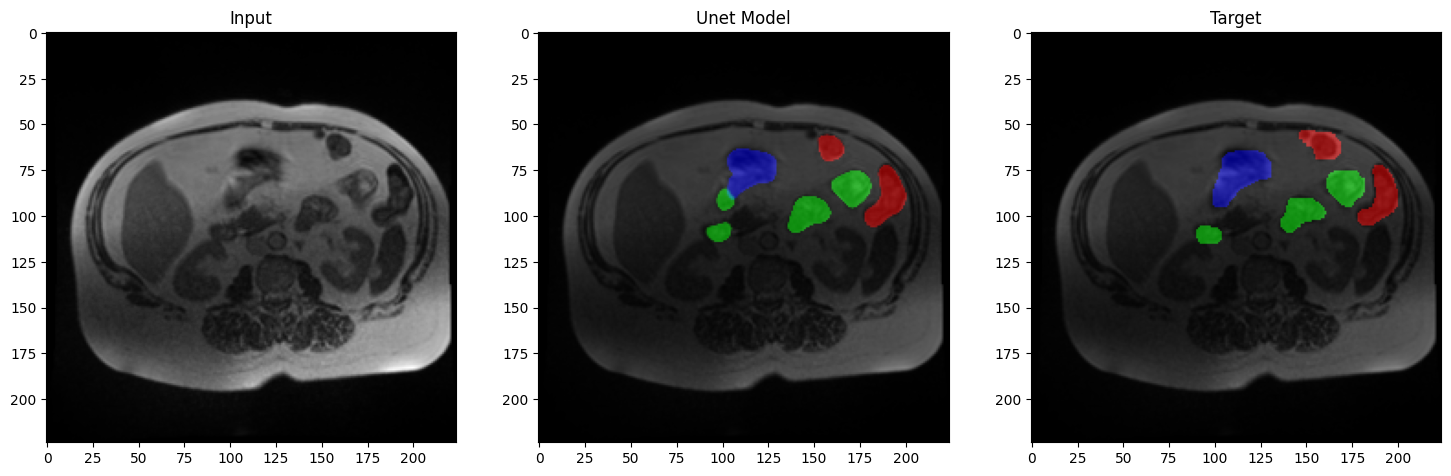

In [91]:
img, mask = next(iter(test_loader))

output = segment(img.to(device), model)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.5);
plt.title('Unet Model')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(mask[0].permute(1, 2, 0).float(), alpha=0.5);
plt.title('Target');

# **UNet++**

In [64]:
import shutil

shutil.make_archive('/kaggle/working/unetModel.pt', 'zip', '/kaggle/working/output')


'/kaggle/working/unetModel.pt.zip'